FORECASTING EXCHANGE RATE BY COMBINING NEWS AND EXCHANGE RATE DATA  "02"


Name Surname : Kaan ERDEN   Student ID : 211805068

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import joblib 


from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score


RANDOM_SEED = 13
WINDOW_SIZE = 7       
TEST_SIZE = 0.2       
TFIDF_MAX_FEATURES = 1000 


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
print("Hücre 1: Kütüphaneler ve global ayarlar yüklendi.")



def mean_absolute_percentage_error(y_true, y_pred):
    """ Ortalama Mutlak Yüzde Hata (MAPE) hesaplar. """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def feature_extraction_sliding_window(df, text_column, target_column, window_size, tfidf_max_features, tfidf_vectorizer=None, is_training=True):
    """ Kayar pencere ve TF-IDF kullanarak özellik çıkarımı yapar. """
    print(f"\n--- Özellik Çıkarımı Başlıyor (Window Size: {window_size}, Max Features: {tfidf_max_features}) ---")
    
    
    df_copy = df.sort_values(by='Date').copy()
    df_copy.reset_index(drop=True, inplace=True)

    processed_features = [] 
    targets = []
    dates_for_output = [] 

    if len(df_copy) < window_size:
        print(f"UYARI: Veri sayısı ({len(df_copy)}) pencere boyutundan ({window_size}) küçük. Özellik çıkarılamıyor.")
        return pd.DataFrame(), None

    for i in range(window_size - 1, len(df_copy)):
        
        window_texts = df_copy[text_column].iloc[i - window_size + 1 : i + 1]
        combined_text = " ".join(window_texts.astype(str)) 
        
        processed_features.append(combined_text)
        targets.append(df_copy[target_column].iloc[i])
        dates_for_output.append(df_copy['Date'].iloc[i])
        
    if not processed_features:
        print("UYARI: Kayar pencere uygulandıktan sonra hiç özellik (metin) bulunamadı.")
        return pd.DataFrame(), None

    print(f"{len(processed_features)} adet kayar pencere örneği oluşturuldu.")

    if is_training or tfidf_vectorizer is None:
        print("Yeni bir TF-IDF vektörleştiricisi eğitiliyor...")
        vectorizer = TfidfVectorizer(
            max_features=tfidf_max_features, 
            min_df=5,  
            max_df=0.7, 
            ngram_range=(1,2) 
        )
        X_tfidf = vectorizer.fit_transform(processed_features)
        print(f"TF-IDF vektörleştiricisi eğitildi. Özellik sayısı: {X_tfidf.shape[1]}")
    else:
        print("Mevcut TF-IDF vektörleştiricisi kullanılıyor (transform)...")
        vectorizer = tfidf_vectorizer
        X_tfidf = vectorizer.transform(processed_features)
        print(f"TF-IDF dönüşümü yapıldı. Özellik sayısı: {X_tfidf.shape[1]}")

    tfidf_feature_names = [f"tfidf_{i}" for i in range(X_tfidf.shape[1])]
    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_feature_names)
    
    output_df = pd.concat([
        pd.DataFrame({'Date': dates_for_output}), 
        tfidf_df, 
        pd.Series(targets, name=target_column)
    ], axis=1)
    
    output_df['Date'] = pd.to_datetime(output_df['Date']) 
    
    print(f"Özellik çıkarımı tamamlandı. Oluşturulan DataFrame boyutu: {output_df.shape}")
    return output_df, vectorizer

print("Hücre 1: Yardımcı fonksiyonlar tanımlandı.")

Hücre 1: Kütüphaneler ve global ayarlar yüklendi.
Hücre 1: Yardımcı fonksiyonlar tanımlandı.




In this cell:

- Essential libraries are imported such as `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `xgboost`, and `joblib`.
- Global configuration variables like `RANDOM_SEED`, `WINDOW_SIZE`, and `TFIDF_MAX_FEATURES` are defined.
- A custom `mean_absolute_percentage_error` function is defined to evaluate regression model performance.
- The core function `feature_extraction_sliding_window` is implemented:
  - It processes time-ordered text data using a sliding window approach.
  - For each window, it combines the last `window_size` texts into a single string.
  - Then, it applies **TF-IDF vectorization** (with n-grams and frequency filtering).
  - It returns a processed DataFrame ready for regression modeling, including both TF-IDF features and the target value.
- The function can be used in both training and inference mode (depending on whether a TF-IDF vectorizer is provided or needs to be fitted).

This setup prepares the data pipeline for transforming time-based text into numerical features for machine learning models.


In [ ]:

print("\n--- HÜCRE 2: Veri Yükleme ve Hazırlık (02.csv'den) ---")

input_csv_file = '02.csv'

df_cleaned = pd.DataFrame() 

try:
    df_cleaned = pd.read_csv(input_csv_file, encoding='utf-8')
    print(f"'{input_csv_file}' dosyası başarıyla okundu. Boyut: {df_cleaned.shape}")
    print("Okunan verinin ilk 3 satırı:")
    print(df_cleaned.head(3).to_string())
    print("\nOkunan verinin sütun bilgileri:")
    df_cleaned.info()

   
    required_columns = ['Date', 'USD_TRY', 'CleanedText']
    missing_columns = [col for col in required_columns if col not in df_cleaned.columns]
    if missing_columns:
        raise ValueError(f"'{input_csv_file}' dosyasında gerekli olan şu sütunlar eksik: {missing_columns}")

    
    df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
    print("\n'Date' sütunu datetime formatına dönüştürüldü.")

    
    df_cleaned.dropna(subset=['CleanedText', 'USD_TRY'], inplace=True)
    df_cleaned['CleanedText'] = df_cleaned['CleanedText'].astype(str)
    df_cleaned['USD_TRY'] = pd.to_numeric(df_cleaned['USD_TRY'], errors='coerce') 
    df_cleaned.dropna(subset=['USD_TRY'], inplace=True) 

    
    initial_rows = len(df_cleaned)
    df_cleaned = df_cleaned[df_cleaned['CleanedText'].str.strip() != '']
    if initial_rows != len(df_cleaned):
        print(f"Sadece boşluk içeren veya boş olan {initial_rows - len(df_cleaned)} 'CleanedText' satırı kaldırıldı.")
    
    if df_cleaned.empty:
        raise ValueError(f"Gerekli işlemlerden sonra '{input_csv_file}' verisi boş kaldı.")

    print(f"\nVeri hazırlığı sonrası kullanılacak satır sayısı: {len(df_cleaned)}")
    print("Hazırlanmış verinin ilk 3 satırı:")
    print(df_cleaned[['Date', 'USD_TRY', 'CleanedText']].head(3).to_string())

except FileNotFoundError:
    print(f"HATA: '{input_csv_file}' dosyası bulunamadı. Lütfen bu dosyanın doğru konumda olduğundan emin olun.")
    df_cleaned = pd.DataFrame() 
except ValueError as ve:
    print(f"Veri Hatası: {ve}")
    df_cleaned = pd.DataFrame()
except Exception as e:
    print(f"'{input_csv_file}' dosyası okunurken veya işlenirken genel bir hata oluştu: {e}")
    df_cleaned = pd.DataFrame()

if df_cleaned.empty:
    print("\n!!! UYARI: HÜCRE 2 SONUNDA 'df_cleaned' BOŞ. Sonraki adımlar çalışmayabilir. !!!")


--- HÜCRE 2: Veri Yükleme ve Hazırlık (02.csv'den) ---
'02.csv' dosyası başarıyla okundu. Boyut: (903, 4)
Okunan verinin ilk 3 satırı:
         Date  USD_TRY                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          



In this step:

- The script attempts to **load the dataset** from the file `'02.csv'`.
- After successful reading, it prints:
  - The shape of the dataset,
  - The first 3 rows,
  - And the column structure (`df.info()`).


- It checks if the required columns (`'Date'`, `'USD_TRY'`, `'CleanedText'`) are present. If not, it raises an error.
- The `'Date'` column is converted to datetime format.
- It removes rows where:
  - `'CleanedText'` or `'USD_TRY'` is missing (null),
  - `'USD_TRY'` can't be converted to a numeric value,
  - `'CleanedText'` is an empty or whitespace-only string.
- If these cleaning steps result in an empty dataset, it raises an error.


- Handles cases where the file doesn't exist,
- Or if expected columns are missing,
- Or if any other unexpected error occurs during processing.

At the end, if `df_cleaned` is empty, it warns that **future steps may not work correctly**.


In [ ]:

print("\n--- HÜCRE 3: Özellik Çıkarımı ---")


df_features = pd.DataFrame() 
tfidf_vectorizer_trained = None 

if not df_cleaned.empty:
    
    
    df_features, tfidf_vectorizer_trained = feature_extraction_sliding_window(
        df=df_cleaned,
        text_column='CleanedText',
        target_column='USD_TRY',
        window_size=WINDOW_SIZE,
        tfidf_max_features=TFIDF_MAX_FEATURES,
        is_training=True 
    )

    if not df_features.empty:
        print("\nÖzellik çıkarımı sonrası oluşturulan 'df_features' (ilk 3 satır):")
        print(df_features.head(3).to_string())
        
        
        try:
            df_features.to_csv('final_model_input_features.csv', index=False, encoding='utf-8')
            print("\n'final_model_input_features.csv' dosyası kaydedildi.")
            if tfidf_vectorizer_trained:
                joblib.dump(tfidf_vectorizer_trained, 'tfidf_vectorizer.pkl')
                print("'tfidf_vectorizer.pkl' dosyası kaydedildi.")
        except Exception as e_save:
            print(f"Özellikli veri veya vektörleyici kaydedilirken hata: {e_save}")
    else:
        print("Özellik çıkarımı sonucu 'df_features' boş.")
else:
    print("'df_cleaned' DataFrame'i boş olduğu için özellik çıkarımı yapılamadı.")

if df_features.empty:
    print("\n!!! UYARI: HÜCRE 3 SONUNDA 'df_features' BOŞ. Sonraki adımlar çalışmayabilir. !!!")


--- HÜCRE 3: Özellik Çıkarımı ---

--- Özellik Çıkarımı Başlıyor (Window Size: 7, Max Features: 1000) ---
897 adet kayar pencere örneği oluşturuldu.
Yeni bir TF-IDF vektörleştiricisi eğitiliyor...
TF-IDF vektörleştiricisi eğitildi. Özellik sayısı: 1000
Özellik çıkarımı tamamlandı. Oluşturulan DataFrame boyutu: (897, 1002)

Özellik çıkarımı sonrası oluşturulan 'df_features' (ilk 3 satır):
        Date   tfidf_0  tfidf_1  tfidf_2   tfidf_3  tfidf_4   tfidf_5  tfidf_6   tfidf_7  tfidf_8   tfidf_9  tfidf_10  tfidf_11  tfidf_12  tfidf_13  tfidf_14  tfidf_15  tfidf_16  tfidf_17  tfidf_18  tfidf_19  tfidf_20  tfidf_21  tfidf_22  tfidf_23  tfidf_24  tfidf_25  tfidf_26  tfidf_27  tfidf_28  tfidf_29  tfidf_30  tfidf_31  tfidf_32  tfidf_33  tfidf_34  tfidf_35  tfidf_36  tfidf_37  tfidf_38  tfidf_39  tfidf_40  tfidf_41  tfidf_42  tfidf_43  tfidf_44  tfidf_45  tfidf_46  tfidf_47  tfidf_48  tfidf_49  tfidf_50  tfidf_51  tfidf_52  tfidf_53  tfidf_54  tfidf_55  tfidf_56  tfidf_57  tfidf_58  tfidf_59 

### Cell 3: Feature Extraction

This cell extracts features from the cleaned text data using a sliding window and TF-IDF.

- If the cleaned data (`df_cleaned`) is not empty:
  - It applies the sliding window feature extraction function.
  - Shows the first 3 rows of the extracted features.
  - Saves the features to `final_model_input_features.csv`.
  - Saves the trained TF-IDF vectorizer to `tfidf_vectorizer.pkl`.

- If the cleaned data is empty or no features are extracted, it shows a warning message.

- **Important:** If `df_features` is empty at the end of this cell, later steps may not work correctly.


In [ ]:

print("\n--- HÜCRE 4: Veri Setini Ayırma ---")

X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='float64'), pd.Series(dtype='float64')

if not df_features.empty:
    X = df_features.drop(columns=['Date', 'USD_TRY'])
    y = df_features['USD_TRY']

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=TEST_SIZE,       
        random_state=RANDOM_SEED,  
        shuffle=True 
    )

    print(f"Eğitim seti (X_train) boyutu: {X_train.shape}")
    print(f"Test seti (X_test) boyutu: {X_test.shape}")
    print("Eğitim setinden ilk 3 X özelliği:")
    print(X_train.head(3).to_string(max_colwidth=10, max_cols=7)) 
else:
    print("'df_features' DataFrame'i boş olduğu için veri seti ayrılamadı.")

if X_train.empty:
    print("\n!!! UYARI: HÜCRE 4 SONUNDA 'X_train' BOŞ. Sonraki adımlar çalışmayabilir. !!!")


--- HÜCRE 4: Veri Setini Ayırma ---
Eğitim seti (X_train) boyutu: (717, 1000)
Test seti (X_test) boyutu: (180, 1000)
Eğitim setinden ilk 3 X özelliği:
      tfidf_0   tfidf_1   tfidf_2  ...  tfidf_997  tfidf_998  tfidf_999
413  0.035509  0.000000  0.026319  ...   0.000000   0.000000   0.000000
789  0.000000  0.018914  0.000000  ...   0.000000   0.028217   0.057491
76   0.000000  0.000000  0.000000  ...   0.206251   0.000000   0.000000




This cell splits the features and target into training and testing sets.

- If the `df_features` is not empty:
  - It separates the features (`X`) and the target (`y`).
  - Splits them into training and test sets using `train_test_split` with a fixed random seed.
  - Prints the shapes of the training and test feature sets.
  - Shows the first 3 rows of the training features.

- If `df_features` is empty, it prints a message saying the split can’t be done.

If the training feature set (`X_train`) is empty at the end, later steps might not work properly.


In [ ]:

print("\n--- HÜCRE 5: Model Eğitimi ve Değerlendirme ---")

models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=100, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=100),
    "XGBoost": xgb.XGBRegressor(random_state=RANDOM_SEED, n_estimators=100, objective='reg:squarederror', n_jobs=-1)
}

model_performance_list = [] 

if not X_train.empty and not X_test.empty:
    for name, model in models.items():
        print(f"\n{name} modeli eğitiliyor...")
        start_train_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_train_time
        print(f"{name} modeli {train_time:.2f} saniyede eğitildi.")

        start_test_time = time.time()
        y_pred = model.predict(X_test)
        test_time = time.time() - start_test_time
        print(f"{name} modeli ile test tahmini {test_time:.4f} saniyede yapıldı.")

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        print(f"Performans ({name}): MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.2f}%")
        
        model_performance_list.append({
            'Model': name, 'MAE': mae, 'R2': r2, 'MAPE': mape,
            'Train Time (s)': train_time, 'Test Time (s)': test_time
        })

    model_performance_df = pd.DataFrame(model_performance_list)
    if not model_performance_df.empty:
        model_performance_sorted = model_performance_df.sort_values(by='MAPE', ascending=True)
        print("\n\n--- Tüm Modellerin Performans Karşılaştırması ---")
        print(model_performance_sorted.to_string())

        best_model_stats = model_performance_sorted.iloc[0]
        best_model_name = best_model_stats['Model']
        print(f"\nEn iyi model (MAPE'ye göre): {best_model_name} (MAPE: {best_model_stats['MAPE']:.2f}%)")
        
       
        best_model_object = models[best_model_name]
        try:
            joblib.dump(best_model_object, f'best_model_{best_model_name.replace(" ", "_")}.pkl')
            print(f"'{best_model_name}' modeli 'best_model_{best_model_name.replace(" ", "_")}.pkl' olarak kaydedildi.")
        except Exception as e_save_model:
            print(f"En iyi model kaydedilirken hata: {e_save_model}")
    else:
        print("Model performans verisi oluşturulamadı.")
else:
    print("Eğitim veya test verisi boş olduğu için model eğitimi yapılamadı.")


--- HÜCRE 5: Model Eğitimi ve Değerlendirme ---

Linear Regression modeli eğitiliyor...
Linear Regression modeli 0.25 saniyede eğitildi.
Linear Regression modeli ile test tahmini 0.0060 saniyede yapıldı.
Performans (Linear Regression): MAE: 0.1903, R2: 0.9853, MAPE: 5.52%

SVR modeli eğitiliyor...
SVR modeli 0.12 saniyede eğitildi.
SVR modeli ile test tahmini 0.0494 saniyede yapıldı.
Performans (SVR): MAE: 0.1833, R2: 0.9846, MAPE: 5.17%

Random Forest modeli eğitiliyor...
Random Forest modeli 8.21 saniyede eğitildi.
Random Forest modeli ile test tahmini 0.0319 saniyede yapıldı.
Performans (Random Forest): MAE: 0.1900, R2: 0.9525, MAPE: 4.45%

Gradient Boosting modeli eğitiliyor...
Gradient Boosting modeli 13.03 saniyede eğitildi.
Gradient Boosting modeli ile test tahmini 0.0089 saniyede yapıldı.
Performans (Gradient Boosting): MAE: 0.1901, R2: 0.9742, MAPE: 4.82%

XGBoost modeli eğitiliyor...
XGBoost modeli 8.53 saniyede eğitildi.
XGBoost modeli ile test tahmini 0.2228 saniyede yapıl


This cell trains and evaluates several regression models:
 Linear Regression, SVR, Random Forest, Gradient Boosting, and XGBoost.
- For each model:
  - Train the model on the training data and measure training time.
  - Predict on the test set and measure prediction time.
  - Calculate performance metrics: MAE (Mean Absolute Error), R2 score, and MAPE (Mean Absolute Percentage Error).
  - Print the performance results.

- After all models are evaluated:
  - Create a summary DataFrame of all model performances.
  - Sort models by MAPE (lower is better) and print the comparison.
  - Identify and print the best model based on MAPE.
  - Save the best model to a `.pkl` file.

- If training or test data is empty, it prints a warning that training cannot proceed.



--- HÜCRE 6: Görselleştirmeler Başlıyor ---
Görselleştirmeler en iyi model olan 'XGBoost' üzerinden yapılacaktır.


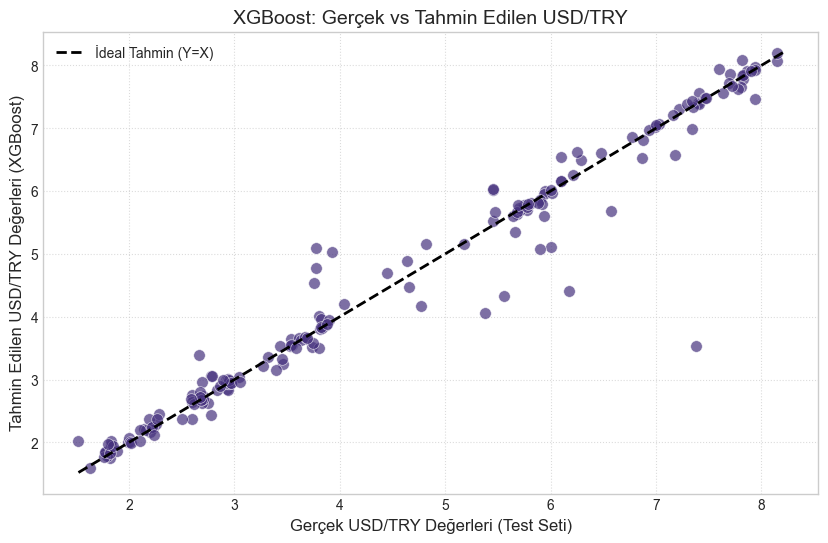

Yorum (Gerçek vs Tahmin): Bu grafik, en iyi modelin tahminlerinin gerçek değerlere ne kadar yakın olduğunu gösterir. Noktaların kesikli çizgiye (ideal tahmin çizgisi) yakın olması, modelin iyi bir performans sergilediğini gösterir.


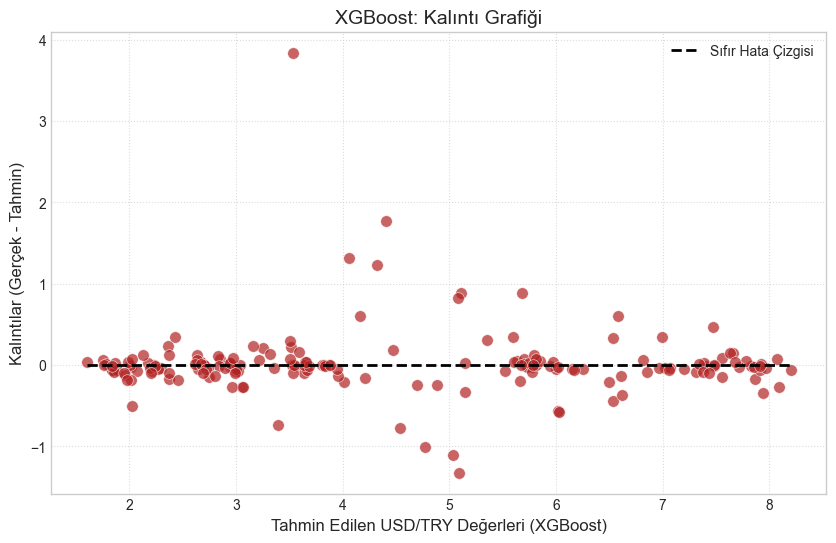

Yorum (Kalıntı Grafiği): Bu grafik, model hatalarının (kalıntıların) tahmin edilen değerlere karşı nasıl dağıldığını gösterir. İdeal bir modelde kalıntılar, sıfır çizgisi etrafında rastgele bir şekilde dağılmalı ve belirgin bir örüntü (pattern) göstermemelidir.


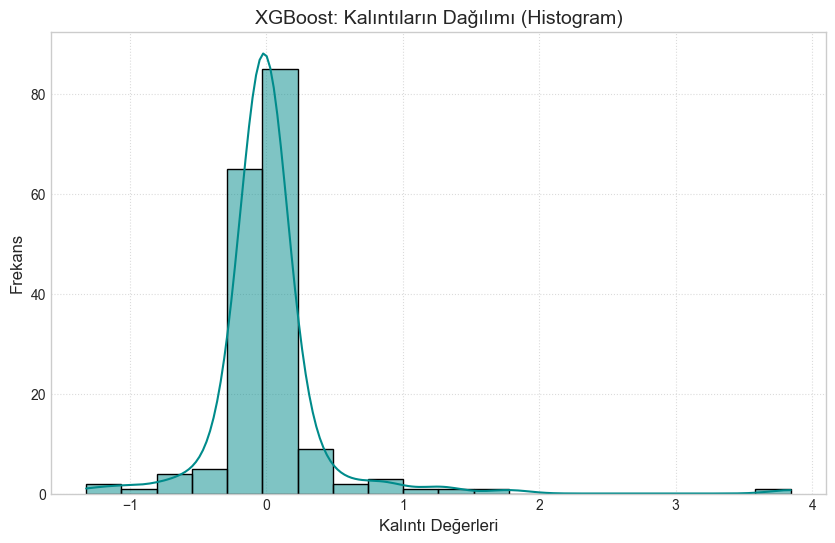

Yorum (Kalıntı Histogramı): Kalıntıların dağılımını gösterir. Normal dağılıma yakın olması (çan eğrisi şeklinde) genellikle modelin hatalarının simetrik ve rastgele olduğunu gösterir.


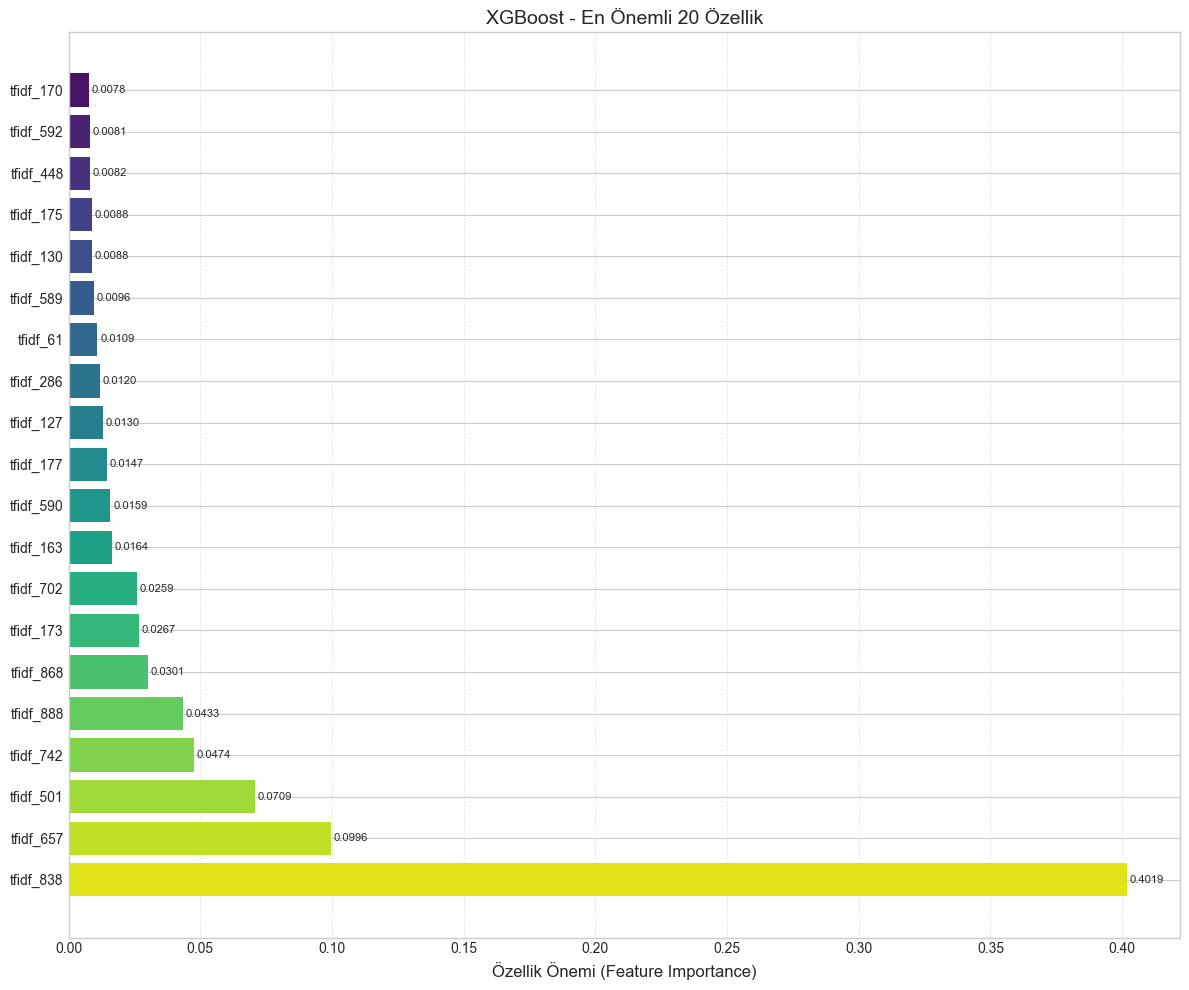

Yorum (Özellik Önemi): Bu grafik, XGBoost modelinin tahmin yaparken hangi TF-IDF özelliklerini (yani hangi kelime/kelime gruplarını temsil eden tfidf_X değerlerini) daha önemli bulduğunu gösterir.


C:\Users\kaan\AppData\Local\Temp\ipykernel_2060\793723073.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=model_performance_sorted, ax=axes_perf[i], palette='viridis', dodge=False)
C:\Users\kaan\AppData\Local\Temp\ipykernel_2060\793723073.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=model_performance_sorted, ax=axes_perf[i], palette='viridis', dodge=False)
C:\Users\kaan\AppData\Local\Temp\ipykernel_2060\793723073.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model'

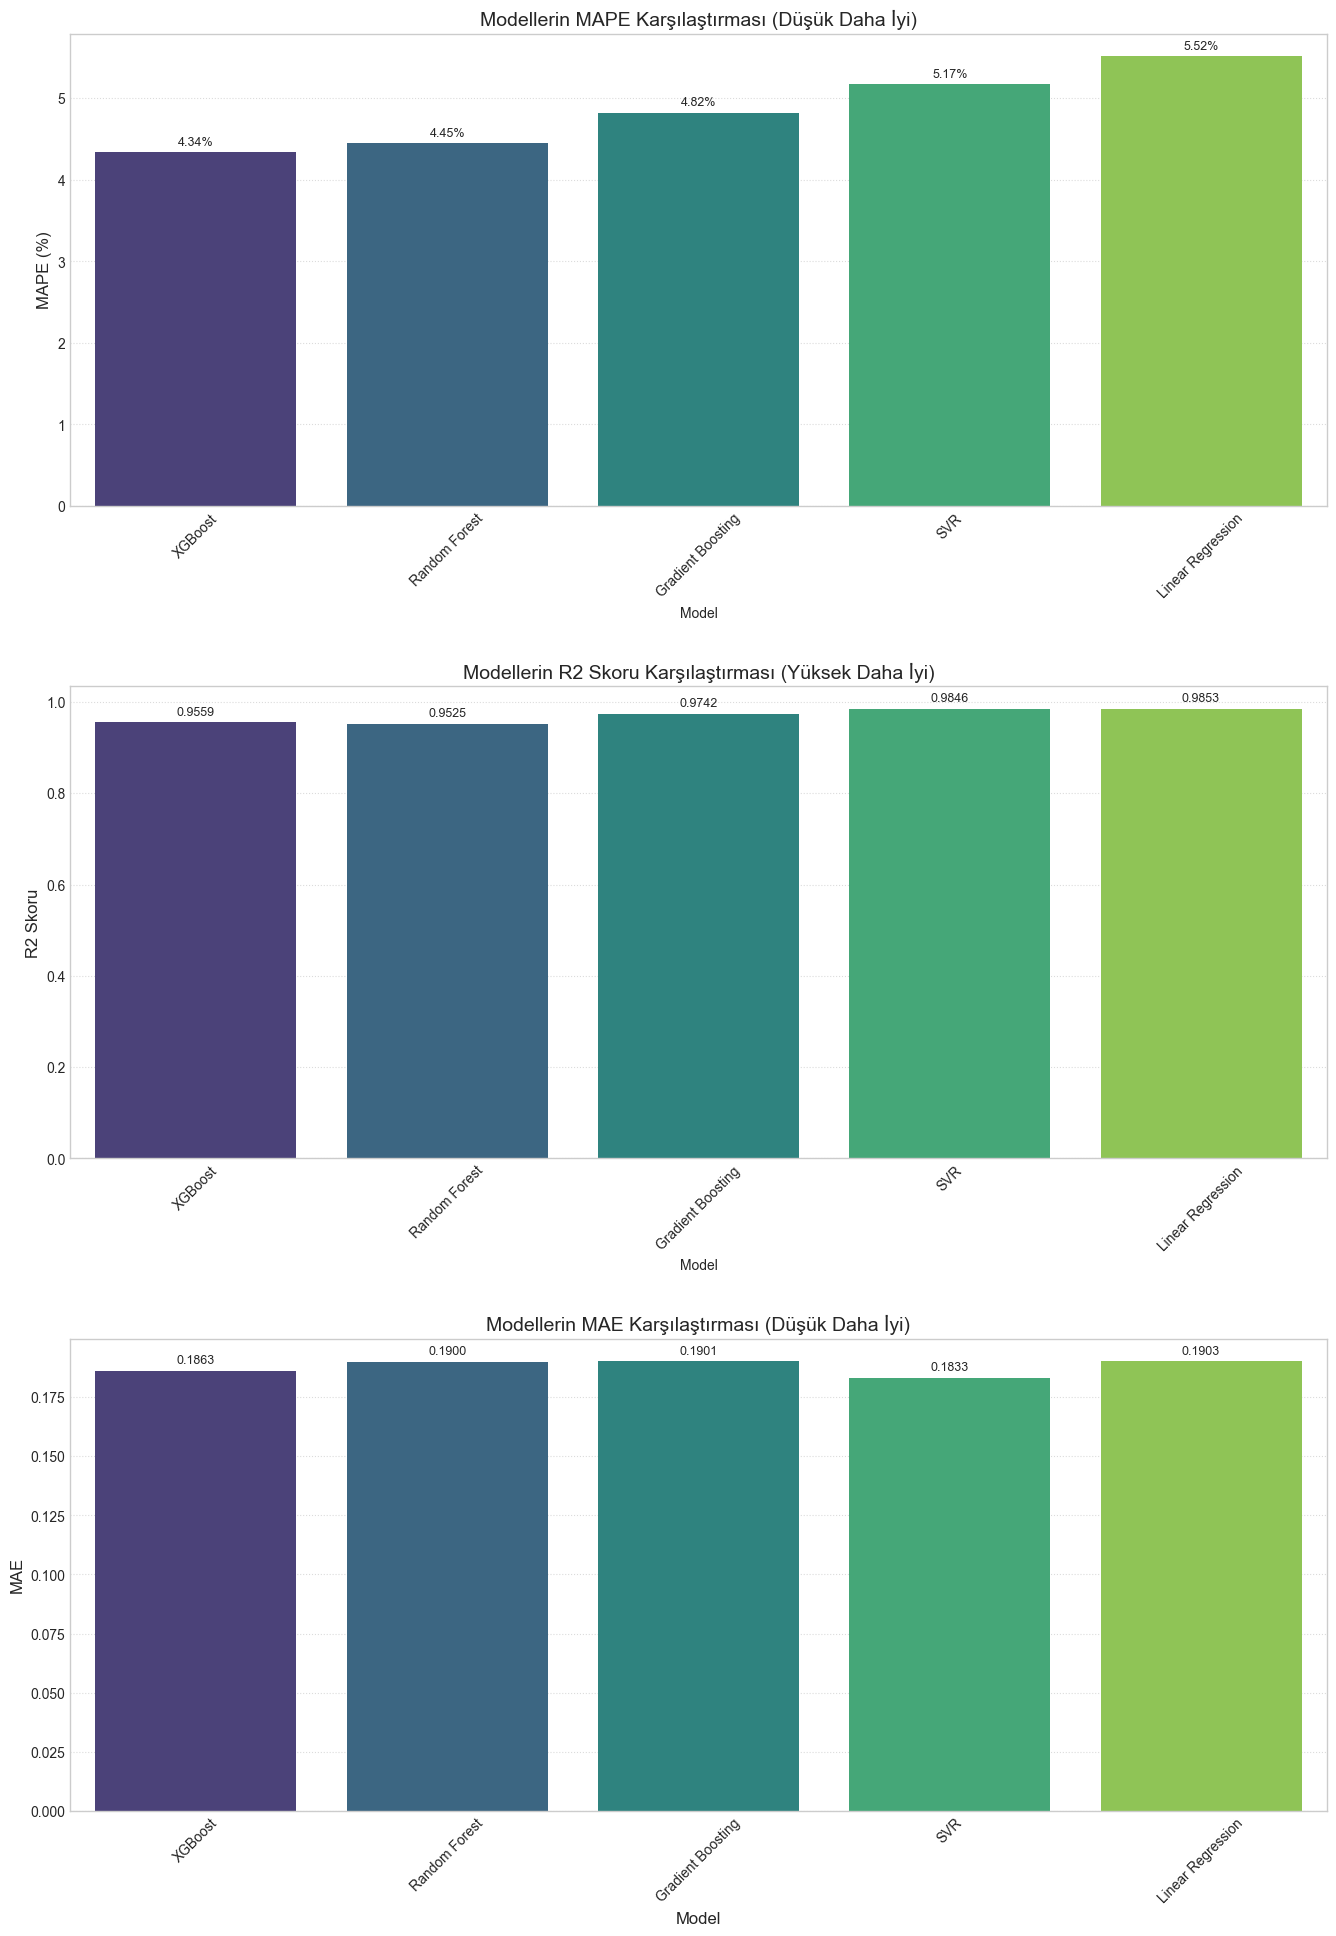

Yorum (Model Karşılaştırma): Farklı modellerin performans metriklerini görsel olarak kıyaslar.

--- HÜCRE 6: Görselleştirmeler Tamamlandı ---


In [ ]:

print("\n--- HÜCRE 6: Görselleştirmeler Başlıyor ---")




if 'models' not in locals() or 'model_performance_sorted' not in locals() or \
   'X_test' not in locals() or 'y_test' not in locals() or X_test.empty:
    print("HATA: Görselleştirme için gerekli değişkenler (models, model_performance_sorted, X_test, y_test) bulunamadı veya test verisi boş.")
    print("Lütfen Hücre 5'in (Model Eğitimi) başarıyla tamamlandığından emin olun.")
else:
    best_model_name_viz = model_performance_sorted.iloc[0]['Model']
    best_model_viz = models[best_model_name_viz] 
    
    
    if not X_test.empty:
        y_pred_best_viz = best_model_viz.predict(X_test)
    else:
        print("X_test boş olduğu için en iyi model tahminleri yapılamıyor.")
        y_pred_best_viz = np.array([]) 

    print(f"Görselleştirmeler en iyi model olan '{best_model_name_viz}' üzerinden yapılacaktır.")

   
    if y_pred_best_viz.size > 0 and not y_test.empty:
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_best_viz, alpha=0.7, edgecolors='w', linewidth=0.5, s=70)
        
        min_val = min(y_test.min(), y_pred_best_viz.min())
        max_val = max(y_test.max(), y_pred_best_viz.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='İdeal Tahmin (Y=X)')
        plt.xlabel("Gerçek USD/TRY Değerleri (Test Seti)", fontsize=12)
        plt.ylabel(f"Tahmin Edilen USD/TRY Değerleri ({best_model_name_viz})", fontsize=12)
        plt.title(f"{best_model_name_viz}: Gerçek vs Tahmin Edilen USD/TRY", fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.show()
        print("Yorum (Gerçek vs Tahmin): Bu grafik, en iyi modelin tahminlerinin gerçek değerlere ne kadar yakın olduğunu gösterir. Noktaların kesikli çizgiye (ideal tahmin çizgisi) yakın olması, modelin iyi bir performans sergilediğini gösterir.")
    else:
        print("Gerçek vs Tahmin grafiği için yeterli veri bulunamadı.")

    
    if y_pred_best_viz.size > 0 and not y_test.empty:
        residuals_viz = y_test - y_pred_best_viz

        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_best_viz, residuals_viz, alpha=0.7, edgecolors='w', linewidth=0.5, color='firebrick', s=70)
        plt.hlines(y=0, xmin=y_pred_best_viz.min(), xmax=y_pred_best_viz.max(), colors='black', linestyles='--', lw=2, label='Sıfır Hata Çizgisi')
        plt.xlabel(f"Tahmin Edilen USD/TRY Değerleri ({best_model_name_viz})", fontsize=12)
        plt.ylabel("Kalıntılar (Gerçek - Tahmin)", fontsize=12)
        plt.title(f"{best_model_name_viz}: Kalıntı Grafiği", fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.show()
        print("Yorum (Kalıntı Grafiği): Bu grafik, model hatalarının (kalıntıların) tahmin edilen değerlere karşı nasıl dağıldığını gösterir. İdeal bir modelde kalıntılar, sıfır çizgisi etrafında rastgele bir şekilde dağılmalı ve belirgin bir örüntü (pattern) göstermemelidir.")

     
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals_viz, kde=True, color='darkcyan', bins=20)
        plt.title(f"{best_model_name_viz}: Kalıntıların Dağılımı (Histogram)", fontsize=14)
        plt.xlabel("Kalıntı Değerleri", fontsize=12)
        plt.ylabel("Frekans", fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.show()
        print("Yorum (Kalıntı Histogramı): Kalıntıların dağılımını gösterir. Normal dağılıma yakın olması (çan eğrisi şeklinde) genellikle modelin hatalarının simetrik ve rastgele olduğunu gösterir.")
    else:
        print("Kalıntı analizi için yeterli veri bulunamadı.")

    
    if hasattr(best_model_viz, 'feature_importances_') and not X_train.empty:
        importances_viz = best_model_viz.feature_importances_
        feature_names_viz = X_train.columns 
        N_feat_imp = 20 
        
        
        indices_viz = np.argsort(importances_viz)[-N_feat_imp:] 
        
        plt.figure(figsize=(12, 10))
        plt.title(f"{best_model_name_viz} - En Önemli {N_feat_imp} Özellik", fontsize=14)
        bars = plt.barh(range(N_feat_imp), importances_viz[indices_viz], color=sns.color_palette("viridis", N_feat_imp), align='center')
        plt.yticks(range(N_feat_imp), [feature_names_viz[i] for i in indices_viz], fontsize=10)
        plt.xlabel("Özellik Önemi (Feature Importance)", fontsize=12)
        plt.gca().invert_yaxis() 
        plt.grid(axis='x', linestyle=':', alpha=0.7)
        
        for bar in bars:
            plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                     f'{bar.get_width():.4f}', 
                     va='center', ha='left', fontsize=8)
        plt.tight_layout()
        plt.show()
        print(f"Yorum (Özellik Önemi): Bu grafik, {best_model_name_viz} modelinin tahmin yaparken hangi TF-IDF özelliklerini (yani hangi kelime/kelime gruplarını temsil eden tfidf_X değerlerini) daha önemli bulduğunu gösterir.")
    elif not hasattr(best_model_viz, 'feature_importances_'):
        print(f"\n{best_model_name_viz} modeli 'feature_importances_' özelliğine sahip değil (örn: Linear Regression, SVR). Bu grafik çizilemiyor.")
    else:
        print("Özellik önemi grafiği için X_train verisi bulunamadı.")

    
if not model_performance_sorted.empty:
    fig_perf, axes_perf = plt.subplots(3, 1, figsize=(14, 20))
    
    metrics_to_plot = [('MAPE', 'MAPE (%)', '%.2f%%'), ('R2', 'R2 Skoru', '%.4f'), ('MAE', 'MAE', '%.4f')]
    titles = ['Modellerin MAPE Karşılaştırması (Düşük Daha İyi)', 
              'Modellerin R2 Skoru Karşılaştırması (Yüksek Daha İyi)', 
              'Modellerin MAE Karşılaştırması (Düşük Daha İyi)']

    for i, (metric, ylabel, fmt) in enumerate(metrics_to_plot):
        sns.barplot(x='Model', y=metric, data=model_performance_sorted, ax=axes_perf[i], palette='viridis', dodge=False)
        axes_perf[i].set_title(titles[i], fontsize=14)
        axes_perf[i].set_ylabel(ylabel, fontsize=12)
        
        axes_perf[i].tick_params(axis='x', rotation=45, labelsize=10) 
        axes_perf[i].grid(axis='y', linestyle=':', alpha=0.7)
        for container in axes_perf[i].containers:
            axes_perf[i].bar_label(container, fmt=fmt, fontsize=9, padding=3)
    
    axes_perf[2].set_xlabel('Model', fontsize=12)
    plt.tight_layout(pad=3.0) 
    plt.show()
    print("Yorum (Model Karşılaştırma): Farklı modellerin performans metriklerini görsel olarak kıyaslar.")
else:
    print("Model performans tablosu boş olduğu için karşılaştırma grafiği çizilemiyor.")
        
    
    if 'df_cleaned' in locals() and not df_cleaned.empty and \
       'Date' in df_cleaned.columns and 'USD_TRY' in df_cleaned.columns:
        
        plt.figure(figsize=(14, 7))
        plt.plot(df_cleaned['Date'], df_cleaned['USD_TRY'], label='USD/TRY Kuru (02.csv)', color='dodgerblue', linewidth=2)
        plt.title('USD/TRY Kurunun Zaman İçindeki Değişimi (02.csv Verisi)', fontsize=14)
        plt.xlabel('Tarih', fontsize=12)
        plt.ylabel('USD/TRY', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.show()
        print("Yorum (USD/TRY Zaman Serisi): Bu grafik, özellik çıkarımı için kullanılan '02.csv' dosyasındaki USD/TRY kurunun zaman içindeki genel trendini, oynaklığını ve olası önemli değişim noktalarını gösterir.")
    else:
        print("USD/TRY zaman serisi grafiği için 'df_cleaned' verisi bulunamadı veya gerekli sütunları içermiyor.")
        
    

print("\n--- HÜCRE 6: Görselleştirmeler Tamamlandı ---")



This cell creates several important plots to understand model results and data:

- Scatter plot of real vs predicted USD/TRY values for the best model.
- Residual plot to check errors and their distribution.
- Histogram of residuals to see error distribution shape.
- Feature importance bar chart if the model supports it.
- Bar charts comparing all models on MAPE, R2, and MAE metrics.
- Time series plot of USD/TRY from the original data.

These visualizations help to evaluate model performance and understand the data better.
